# Temporal consistency of preterm dysmaturation - microscale
Here, we investigated cellular consistency among preterm individuals in the BLS-26 cohort. CT deviations in adulthood can be traced back to glial cellular underpinnings.

1. Preprocess AHBA data
2. Extract cell-type specific gene expression
3. Correlate cell-type specific gene expression with IBAPs
4. Associate gestational age with individual correlation coefficients

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np

import abagen

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

import sys
sys.path.append('code')
from imaging_transcriptomics import *
from plotting import plot_celltype_correlations, correlation_plot, plot_individual_brain_maps, plot_gene_exp

# some settings
scale = 1  # scale for brain plots; run with scale = 10 for higher resolution
refit_gene_corr = False  # whether to re-compute gene correlations
gene_corr_supplement = False  # whether to re-compute gene correlations for supplementary analysis (i.e., using burt2020 instead of spin_test)


# 1. Preprocess AHBA data
We will download the Allen Human Brain Atlas (AHBA) gene expression data in Desikan-Killiany parcellation using `abagen.get_expression_data()`. The AHBA contains regional gene expression from 6 adult human brains that were analyzed post-mortem. When running the code for the first time, the downlaod will take a few minutes. Increase `n_proc` for a faster download but keep the limited capacities of your machine in mind. The data will be saved in your home directory (`abagen-data` folder).

In [3]:
out_dir_ahba = join('outputs/AHBA')
os.makedirs(out_dir_ahba, exist_ok=True)

n_proc = 4  # CPU count for downloading AHBA data

In [4]:
# define parcellation
atlas = abagen.fetch_desikan_killiany(surface=True)
atlas_info = pd.read_csv(atlas['info']) 

# parcellate expression data
expression = abagen.get_expression_data(atlas['image'], atlas['info'], lr_mirror=None, n_proc=n_proc)

In [5]:
# retrieve ROI names from atlas_info
cortex_rois = atlas_info.loc[atlas_info['structure'] == 'cortex']
rois = [m+'_'+str(n) for m,n in zip(cortex_rois['hemisphere'],cortex_rois['label'])]

# rename labels of expression into DK names
expression.index = rois

# transform matrix
expression = expression.T
expression.head()

,L_bankssts,L_caudalanteriorcingulate,L_caudalmiddlefrontal,L_cuneus,L_entorhinal,L_fusiform,L_inferiorparietal,L_inferiortemporal,L_isthmuscingulate,L_lateraloccipital,...,R_rostralanteriorcingulate,R_rostralmiddlefrontal,R_superiorfrontal,R_superiorparietal,R_superiortemporal,R_supramarginal,R_frontalpole,R_temporalpole,R_transversetemporal,R_insula
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0.440726,0.678336,0.520608,0.317040,0.711983,0.649082,0.419474,0.640879,0.353653,0.313056,...,0.549433,0.495912,0.630154,0.380599,0.669758,0.255569,0.642150,0.874019,0.575880,0.698525
A1BG-AS1,0.589278,0.431307,0.446375,0.307230,0.261514,0.586919,0.443861,0.636120,0.448406,0.301562,...,0.731299,0.515659,0.543213,0.301384,0.490495,0.460440,0.713728,0.809826,0.257826,0.568063
A2M,0.381510,0.572806,0.609580,0.451889,0.699565,0.444880,0.415128,0.408960,0.554756,0.509786,...,0.672099,0.412369,0.471484,0.235769,0.483720,0.616346,0.140265,0.938905,0.764119,0.679651
A2ML1,0.436797,0.671694,0.459314,0.477776,0.514992,0.455946,0.498819,0.518881,0.485929,0.509053,...,0.315118,0.490154,0.509085,0.572556,0.616141,0.509861,0.354118,0.087033,0.981280,0.522676
A3GALT2,0.467330,0.480824,0.501768,0.474542,0.455938,0.459009,0.456800,0.447463,0.409539,0.504859,...,0.392705,0.454631,0.406274,0.585044,0.419737,0.452747,0.381271,0.027779,0.818433,0.423293


In [6]:
# save to csv
expression.to_csv(os.path.join(out_dir_ahba, 'expression_ahba.csv'), sep=',')
expression.to_csv(os.path.join(out_dir_ahba,'expression_ahba_vals.csv'), sep=',', header=None, index=None)

In [7]:
# generate a report of preprocessing steps
generator = abagen.reporting.Report(atlas['image'], atlas['info'])
report = generator.gen_report()

# save report
with open(join(out_dir_ahba, 'report_ahba.txt'), 'w', encoding='utf-8') as f:
    f.write(report)

# 2. Extract cell-type specific gene expression
This part of the script will follow the steps presented in [Di Biase et al. 2022](https://doi.org/10.1038/s41380-022-01460-7): 

1. A cell-type-specific gene set is determined based on some single-cell seq data. [Seidlitz et al. 2020](https://doi.org/10.1038/s41467-020-17051-5) have compiled a cell-specific gene set list for 8 cell types from all available large-scale single-cell studies of the adult human cortex. This is freely available [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-17051-5/MediaObjects/41467_2020_17051_MOESM8_ESM.xlsx). The file is downloaded already and saved in `/data/cell_types/`.
2. Mean expression of each cell type-specific gene set is determined. 
3. Correlation for both measures with each of the 8 cell-type-specific maps is performed, respectively.

In [8]:
# directories
data_cell_dir = join('data', 'cell_types')
out_dir = join('outputs', 'consistency_microscale')
os.makedirs(out_dir, exist_ok=True)

In [9]:
gene_labels = expression.index
celltypes=["Astro", "Endo", "Neuro-Ex", "Neuro-In", "Micro", "Oligo", "OPC", "Per"]

In [10]:
# load bls_26 CT deviation scores
bls_26_ct = pd.read_csv(join('outputs', 'spatial_heterogeneity', 'BLS-26', 'IBAP_CT', 'BLS-26_CT_centiles_per_subject.csv'))
bls_26_ct_vals = bls_26_ct.filter(regex='centile_CT|participant').set_index('participant')
bls_26_ct_vals_dupl = bls_26_ct_vals.copy()
bls_26_ct_vals_dupl.columns = bls_26_ct_vals.columns + '_dupl'

# duplicate cortical data to match gene data
cortical_data = bls_26_ct_vals.merge( bls_26_ct_vals_dupl, on='participant', how='inner')

### Extract cell-type specific gene expression for each cell type

In [11]:
cell_genes_df = pd.read_excel(join(data_cell_dir, '41467_2020_17051_MOESM8_ESM.xlsx'))
cell_genes_df.drop(columns=['Type', 'Paper', 'Cluster'], inplace=True)

# initialize dictionary to store all genes for each cell type
cell_type_genes = {}

for index, row in cell_genes_df.iterrows():
    # get cell type
    cell_type = row['Class']
    if pd.isna(cell_type):
        continue
    
    # combine genes from all other columns
    genes = []
    for col in cell_genes_df.columns:
        if col != 'Type' and pd.api.types.is_string_dtype(cell_genes_df[col]):
            cell_genes = str(row[col]).split(",") if pd.notna(row[col]) else []
            genes.extend([gene.strip() for gene in cell_genes if gene.strip()])

    # Update the dictionary
    if cell_type not in cell_type_genes:
        cell_type_genes[cell_type] = set()
    cell_type_genes[cell_type].update(genes)

# keep each gene once per cell type only
cell_type_genes = {k: set(v) for k, v in cell_type_genes.items()}

# save csv file containing list of genes for each cell type
output_file = join(out_dir, "cell_type_genes.csv")
with open(output_file, 'w') as f:
    f.write("Cell Type,Genes\n")
    for cell_type, genes in cell_type_genes.items():
        f.write(f"{cell_type},\"{', '.join(genes)}\"\n")

# 3. Correlate cell-type specific gene expression with IBAPs
We will correlate the regional profile of cell-type specific gene expression (`expressionAllMean`) with the regional individual brain aberration patterns (IBAPs) of each subject (`cortical_data`). As regions in brain maps are not statistically independent but spatially autocorrelated, we will use `spin tests` to assess the correlation significance. These tests will take into account the spatially autocorrelated structure of the data. Find more information on spatial autocorrelation preserving significance assessment in the following great papers:
- [Alexander-Bloch et al. 2018](https://doi.org/10.1016/j.neuroimage.2018.05.070)
- [Markello and Misic 2021](https://doi.org/10.1016/j.neuroimage.2021.118052)
- [Larivière et al. 2021](https://doi.org/10.1038/s41592-021-01186-4)


This will take about 60-90 minutes to run, depending on your machine, as the spin tests are computationally intensive. Adjust the number of permutations (`n_rot`) to speed up the process.

In [12]:
if refit_gene_corr:

    for cell in celltypes:
        print(cell)
        expressionAllMean = get_mean_expression_cell_type(cell, expression, cell_type_genes, out_dir)
        
        # correlation of cortical data with mean expression (using Alexander-Bloch's spin test)
        corr_coeffs = cell_correlation(expressionAllMean, cortical_data, n_rot=1000 )
        
        # save corr_coeffs
        corr_coeffs.to_csv(join(out_dir, f'correlation_centiles_{cell}.csv'))

### Summarize correlation results

In [13]:
# save spearman rhos per cell type and subject
all_cell_corr = pd.DataFrame(index = cortical_data.index)

for cell in celltypes:
    cell_corr = pd.read_csv(join(out_dir, f'correlation_centiles_{cell}.csv'))

    # save spearman
    all_cell_corr = all_cell_corr.merge(cell_corr[['Spearman_r', 'participant']], on='participant')
    all_cell_corr.rename(columns={'Spearman_r': cell}, inplace=True)
    
    # save p_spin
    all_cell_corr = all_cell_corr.merge(cell_corr[['pspin', 'participant']], on='participant')
    all_cell_corr.rename(columns={'pspin': cell+'_pspin'}, inplace=True)


# merge with meta information and save
cols_to_drop = bls_26_ct.filter(regex='centile').columns
meta = bls_26_ct.drop(columns=cols_to_drop)
all_cell_corr = all_cell_corr.merge(meta, on='participant')
all_cell_corr.to_csv(os.path.join(out_dir, 'all_correlations_cell_types.csv'))


# filter groups
all_cell_corr_pt = all_cell_corr[all_cell_corr['dx']=='preterm']
all_cell_corr_ft = all_cell_corr[all_cell_corr['dx']=='CN']

In [14]:
# each subject's correlation of individual brain aberration pattern with cell type gene expression
all_cell_corr_pt_unfiltered = all_cell_corr_pt.filter(celltypes)
all_cell_corr_pt_unfiltered.head()

,Astro,Endo,Neuro-Ex,Neuro-In,Micro,Oligo,OPC,Per
1,-0.018405,-0.111805,0.233843,0.110430,0.146782,-0.135632,-0.002902,-0.193367
4,0.043531,0.074689,-0.110354,-0.027111,-0.107834,0.038719,-0.006186,0.066212
5,-0.462569,-0.053993,0.166103,0.077973,-0.268209,0.259809,-0.356645,-0.225061
9,0.077133,0.188862,0.096378,0.179086,-0.011532,0.017794,0.105772,0.029708
13,0.250263,0.169464,-0.331367,-0.276075,0.276839,-0.009164,0.195735,0.085152


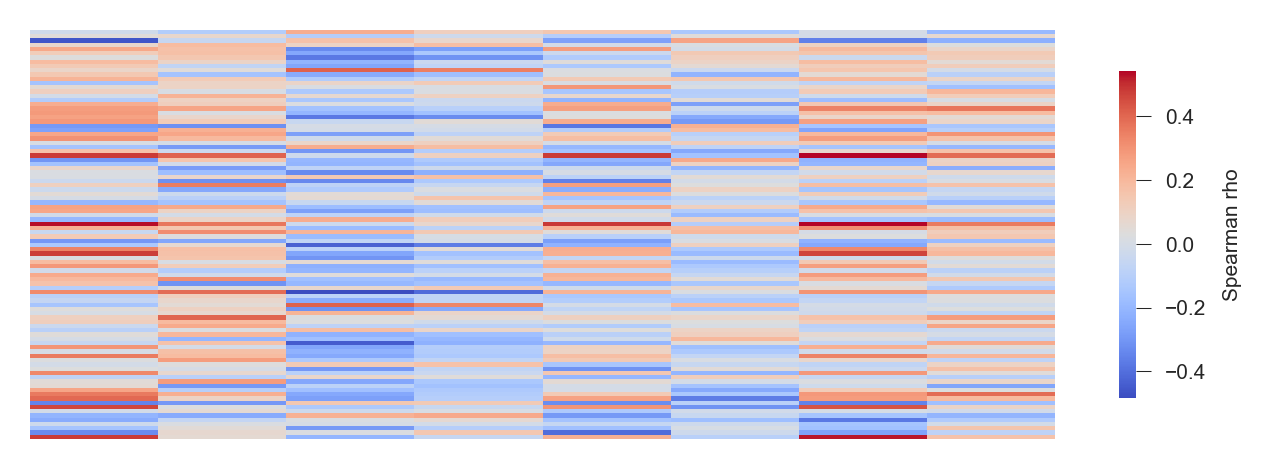

In [15]:
# plot correlation heatmap for all preterm subjects
outname = join(out_dir, 'correlation_heatmap.svg')
plot_celltype_correlations(all_cell_corr_pt_unfiltered, outname=outname)

# source data
all_cell_corr_pt_unfiltered.to_csv(join(out_dir, 'source_corr_celltypes_pt.csv'), index=False)

In [16]:
# filtered for significant correlations only (p-spin-based)
all_cell_corr_filtered = all_cell_corr_pt.copy()
for cell in celltypes:
    all_cell_corr_filtered[cell] = all_cell_corr_filtered.apply(lambda x: x[cell] if x[f'{cell}_pspin'] < 0.05 else None, axis=1)

# Keep only Spearman rho values
all_cell_corr_filtered = all_cell_corr_filtered.filter(celltypes)

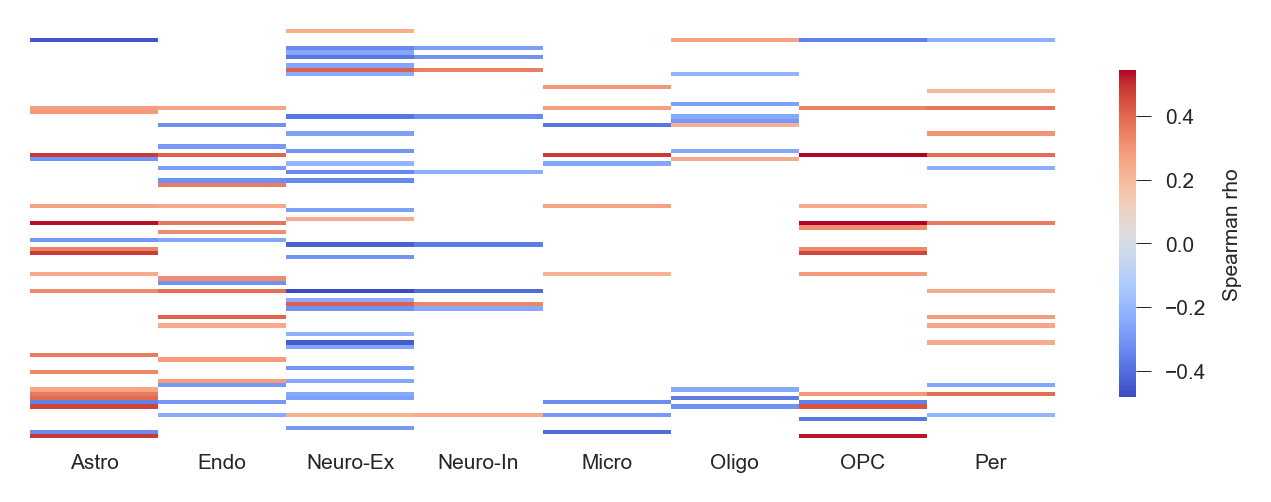

In [17]:
outname = join(out_dir, 'correlation_heatmap_pspin.svg')
plot_celltype_correlations(all_cell_corr_filtered, outname=outname, xlabels_bool=True)

# source data
all_cell_corr_filtered.to_csv(join(out_dir, 'source_corr_celltypes_pt_filtered.csv'), index=False)

## Supplementary analysis: using burt2020 instead of spin test
Since criticism on the `spin test` exists, we will also present the results for a different significance assessment method, `brainSMASH`. This method creates surrogate brain maps that preserve the spatial autocorrelation structure of the data using variogram matching. Since brain map is computationally intensive, I have run the analysis on an external server cluster inside a docker container (with all necessary libraries installed) and saved the results in the `outputs/consistency_microscale/supplement_brainSMASH/` directory. The results are then loaded and plotted below.
- [Burt et al., 2020](https://doi.org/10.1016/j.neuroimage.2020.117038)

In [18]:
if gene_corr_supplement:
    
    supp_dir = join(out_dir, 'supplement_brainSMASH')
    
    # save spearman rhos per cell type and subject
    all_cell_corr_burt = pd.DataFrame(index = cortical_data.index)

    for cell in celltypes:
        # laod correlation coefficients for supplementary analysis computed with brainSMASH
        try:
            cell_corr = pd.read_csv(join(supp_dir, f'correlation_centiles_{cell}_burt2020.csv'))
        except FileNotFoundError:
            print('Run /code/3_microscaleConsistency_burt.py to compute gene correlations for supplementary analysis')


        # save spearman
        all_cell_corr_burt = all_cell_corr_burt.merge(cell_corr[['Spearman_r', 'participant']], on='participant')
        all_cell_corr_burt.rename(columns={'Spearman_r': cell}, inplace=True)
        
        # save pburt
        all_cell_corr_burt = all_cell_corr_burt.merge(cell_corr[['pburt', 'participant']], on='participant')
        all_cell_corr_burt.rename(columns={'pburt': cell+'_pburt'}, inplace=True)
        


    # merge with meta information and save
    cols_to_drop = bls_26_ct.filter(regex='centile').columns
    meta = bls_26_ct.drop(columns=cols_to_drop)
    all_cell_corr_burt = all_cell_corr_burt.merge(meta, on='participant')
    all_cell_corr_burt.to_csv(os.path.join(supp_dir, 'all_correlations_cell_types_burt2020.csv'))


    # filter groups
    all_cell_corr_burt_pt = all_cell_corr_burt[all_cell_corr_burt['dx']=='preterm']
    all_cell_corr_burt_ft = all_cell_corr_burt[all_cell_corr_burt['dx']=='CN']
    
    
    # each subject's correlation of individual brain aberration pattern with cell type gene expression
    all_cell_corr_burt_pt_unfiltered = all_cell_corr_burt_pt.filter(celltypes)
    
    # plot correlation heatmap for all preterm subjects
    outname = join(supp_dir, 'correlation_heatmap_brainSMASH.svg')
    plot_celltype_correlations(all_cell_corr_burt_pt_unfiltered, outname=outname)
    
    
    ### filtered for significant correlations only (p-smash-based)
    all_cell_corr_burt_filtered = all_cell_corr_burt_pt.copy()
    for cell in celltypes:
        all_cell_corr_burt_filtered[cell] = all_cell_corr_burt_filtered.apply(lambda x: x[cell] if x[f'{cell}_pburt'] < 0.05 else np.nan, axis=1)

    # Keep only Spearman rho values
    all_cell_corr_burt_filtered = all_cell_corr_burt_filtered.filter(celltypes)
    
    outname = join(supp_dir, 'correlation_heatmap_brainSMASH.svg')
    plot_celltype_correlations(all_cell_corr_burt_filtered, outname=outname, xlabels_bool=True)
    
    
    # source data
    all_cell_corr_burt_filtered.to_csv(join(supp_dir, 'source_corr_celltypes_pt_filtered_burt2020.csv'), index=False)

# 4. Associate gestational age with individual correlation coefficients
We will now test if there is a relationship between the correlation strength between cell-type specific gene expression and IBAPs with gestational age using Spearman's rank correlation.

In [19]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')  # reset to default matplotlib settings

Correlating Spearman correlation coefficient of Astro and deviation scores with GA
Correlation between GA and Astro: r=-0.266 with DOF=94, p=0.009, CI=(-0.443, -0.069)


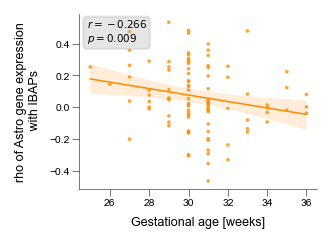

Correlating Spearman correlation coefficient of Endo and deviation scores with GA
Correlation between GA and Endo: r=-0.203 with DOF=94, p=0.047, CI=(-0.388, -0.002)


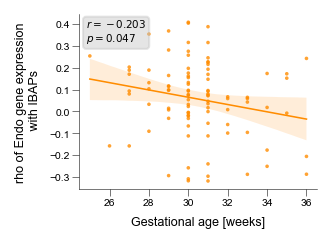

Correlating Spearman correlation coefficient of Neuro-Ex and deviation scores with GA
Correlation between GA and Neuro-Ex: r=0.150 with DOF=94, p=0.146, CI=(-0.052, 0.340)


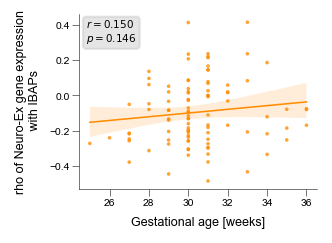

Correlating Spearman correlation coefficient of Neuro-In and deviation scores with GA
Correlation between GA and Neuro-In: r=0.094 with DOF=94, p=0.363, CI=(-0.109, 0.289)


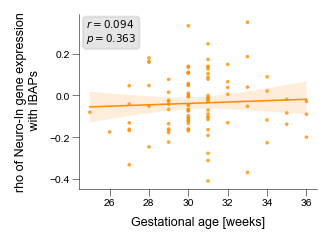

Correlating Spearman correlation coefficient of Micro and deviation scores with GA
Correlation between GA and Micro: r=-0.174 with DOF=94, p=0.090, CI=(-0.362, 0.028)


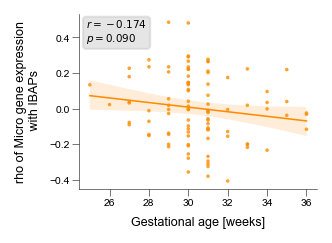

Correlating Spearman correlation coefficient of Oligo and deviation scores with GA
Correlation between GA and Oligo: r=0.213 with DOF=94, p=0.037, CI=(0.014, 0.397)


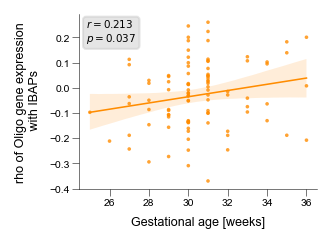

Correlating Spearman correlation coefficient of OPC and deviation scores with GA
Correlation between GA and OPC: r=-0.234 with DOF=94, p=0.022, CI=(-0.415, -0.035)


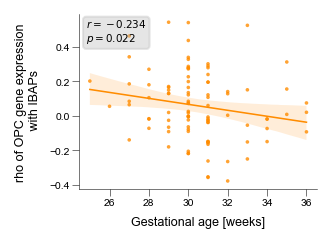

Correlating Spearman correlation coefficient of Per and deviation scores with GA
Correlation between GA and Per: r=-0.196 with DOF=94, p=0.055, CI=(-0.382, 0.004)


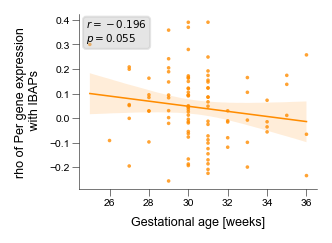

In [20]:
preterm_var = 'GA'
for cell in celltypes:
    print(f"Correlating Spearman correlation coefficient of {cell} and deviation scores with {preterm_var}")
    outname = join(out_dir, f'correlation_PT_{cell}_{preterm_var}.svg')
    correlation_plot(y=cell, 
                    x=preterm_var, 
                    data=all_cell_corr_pt, 
                    color='darkorange', 
                    ylabel=f'rho of {cell} gene expression\n with IBAPs', 
                    xlabel= 'Gestational age [weeks]',
                    outname=outname)

# source data
all_cell_corr_pt_source = all_cell_corr_pt[celltypes+['GA']].sort_values(by='GA')
all_cell_corr_pt_source = all_cell_corr_pt_source.reset_index(drop=True)
all_cell_corr_pt_source.to_csv(join(out_dir, 'source_corr_celltypes_pt_GA.csv'), index=False)

In [21]:
# some other example IBAPs
plot_individual_brain_maps(cortical_data=bls_26_ct, sub_id='BEST-BN-007', outdir=out_dir, scale=scale)
plot_individual_brain_maps(cortical_data=bls_26_ct, sub_id='BEST-MUC-014', outdir=out_dir, scale=scale)
plot_individual_brain_maps(cortical_data=bls_26_ct, sub_id='BEST-MUC-093', outdir=out_dir, scale=scale)

# source data
sub_ids = ['BEST-BN-007', 'BEST-MUC-014', 'BEST-MUC-093']
source_data = bls_26_ct[bls_26_ct['participant'].isin(sub_ids)].copy()
source_data = source_data.filter(regex='centile_CT|participant')
source_data.to_csv(join(out_dir, 'source_individual_brain_maps.csv'), index=False)

Plotted brain map and saved it to outputs/consistency_microscale/BEST-BN-007_CT_individual_centiles.svg
Plotted individual rCTD map for subject BEST-BN-007 and saved it to outputs/consistency_microscale
Plotted brain map and saved it to outputs/consistency_microscale/BEST-MUC-014_CT_individual_centiles.svg
Plotted individual rCTD map for subject BEST-MUC-014 and saved it to outputs/consistency_microscale
Plotted brain map and saved it to outputs/consistency_microscale/BEST-MUC-093_CT_individual_centiles.svg
Plotted individual rCTD map for subject BEST-MUC-093 and saved it to outputs/consistency_microscale


In [22]:
out_dir_cell_maps = join(out_dir, 'cell_maps')
os.makedirs(out_dir_cell_maps, exist_ok=True)

for celltype in celltypes:
    print(celltype)
    plot_gene_exp(celltype=celltype, it_dir=out_dir, out_dir=out_dir_cell_maps, scale=scale)

Astro
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Astro_expression.svg
Endo
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Endo_expression.svg
Neuro-Ex
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Neuro-Ex_expression.svg
Neuro-In
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Neuro-In_expression.svg
Micro
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Micro_expression.svg
Oligo
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Oligo_expression.svg
OPC
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/OPC_expression.svg
Per
Plotted brain map and saved it to outputs/consistency_microscale/cell_maps/Per_expression.svg
